In [1]:
import requests
import time
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, PoissonRegressor, LassoCV, Lasso, RidgeCV, Ridge
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
import xgboost as xgb

# 1. Data Collection Using Spotify API

This section shows the code blocks we used to request data from Spotify API. We've submitted all data needed in this notebook, **so there is no need to rerun this section.**

In [ ]:
"""
the first time run this colab, please uncomment the following four Spotify 
packages related code lines as follows. Normally, after the first run, a runtime
restart (then a re-reun) is required to fully make all the dependencies work
"""

# !pip install spotipy
# !pip3 install spotipy --upgrade
# import spotipy
# from spotipy.oauth2 import SpotifyClientCredentials

'\nthe first time run this colab, please uncomment the following four spotipy \npackages related code lines as follows. Normally, after the first run, a runtime\nrestart (then a re-reun) is required to fully make all the dependencies work\n'

In [ ]:
CLIENT_ID = "7ea3a789250d45aeaf2f230a9891bc0d"
CLIENT_SECRET = "d5eaa908104f4bceb6d038968542d884"

In [ ]:
manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(client_credentials_manager=manager)

In [ ]:
def get_tracks(year, num):
    artist_name = []
    track_name = []
    popularity = []
    track_id = []
    type_release = []
    collaboration = []
    danceability = []
    valence = []
    energy = []
    tempo = [] 
    key = []
    mode = []
    time_signature = []
    speechiness = []
    instrumentalness = []
    loudness = []
    duration_ms = []
    acousticness = []
    release_date = []
    for i in range(0,num,50):
        batch_tracks = sp.search(q=f'year:{year} AND genre:electronic', type='track', limit=50, offset=i)
        batch_track_id = []
        for j, track in enumerate(batch_tracks['tracks']['items']):
            artist_name.append(track['artists'][0]['name'])
            if len(track['artists']) > 1:
                collaboration.append("Y")
            else:
                collaboration.append("N")
            track_name.append(track['name'])
            track_id.append(track['id'])
            batch_track_id.append(track['id'])
            popularity.append(track['popularity'])
            type_release.append(track['album']["album_type"])
            release_date.append(track['album']["release_date"])

        time.sleep(1)
        features = sp.audio_features(tracks=batch_track_id)

        for feature, id in zip(features, batch_track_id):
            # sanity check to make sure the ids do match
            if feature["id"] != id:
                print("The IDs do not match!")

            danceability.append(feature["danceability"])
            valence.append(feature["valence"])
            energy.append(feature["energy"])
            tempo.append(feature["tempo"])
            key.append(feature["key"])
            mode.append(feature["mode"])
            duration_ms.append(feature["duration_ms"])
            loudness.append(feature["loudness"])
            time_signature.append(feature["time_signature"])
            acousticness.append(feature["acousticness"])
            speechiness.append(feature["speechiness"])
            instrumentalness.append(feature["instrumentalness"])
        time.sleep(1)
        base = 200
        if i % base == 0:
            print(f"Collected {i + base} pieces of data for year {year}")

    labels = {'artist_name' : artist_name, 
              'track_name' : track_name, 
              'track_id' : track_id, 
              'type_release' : type_release,
              'collaboration' : collaboration,
              'danceability' :danceability,
              'valence' :valence,
              'energy' :energy,
              'tempo' :tempo, 
              'key' :key,
              'mode' :mode,
              'loudness' :loudness,
              'time_signature':time_signature,
              'speechiness' :speechiness,
              'duration_ms' : duration_ms,
              'acousticness' : acousticness,
              'instrumentalness' :instrumentalness,
              'release_date': release_date,
              'popularity' : popularity}
    result = pd.DataFrame(labels)
    return result

In [ ]:
# get the data over years
years = range(2016, 2021)
num = 1000
data_list = []
for year in years:
    data_list.append(get_tracks(year, num))

In [ ]:
data_list.append(get_tracks(2021, num))

In [ ]:
result = pd.concat(data_list, axis=0, ignore_index=True)
display(result.head())
result = result.sample(frac=1).reset_index(drop=True)
display(result.head())

In [ ]:
print(result.shape)

In [ ]:
dictionary = result.to_dict('records')

In [ ]:
with open("all_data.json", "w") as f:
    json.dump(dictionary, f, indent = 4)

In [ ]:
data_2022 = get_tracks(2022, num)
display(data_2022.head())
print(data_2022.shape)
data_2022 = data_2022.to_dict('records')
with open("data_2022.json", "w") as f:
    json.dump(data_2022, f, indent = 4)

# 2. Exploratory Data Analysis (EDA)

We start by inspecting some summary statistics of the dataset. According to the info table, 5 cloumns in the dataset (`artist_name`, `track_name`, `track_id`, `type_release`, `collboration`) are categorical, while the other 14 columns are numerical. Also, the dataset does not have any null values. 

In [3]:
sns.set(color_codes=True)
sns.set(rc={'savefig.dpi':500})

In [4]:
with open('all_data.json', 'r') as f:
    data = json.load(f)
    df = pd.DataFrame(data)
df.head()

artist_name              track_name                track_id type_release  \
0  Emancipator            Rappahannock  3D8AeuoC0w5cK7Kt7p3KQf        album   
1  Blue States   Protect Me Everywhere  1TpdbH4W8aqx1CZqu6EGFH        album   
2     Four Tet                Memories  0QIyJvZOkzMFLJb6mTLFUM        album   
3       Lookas  On My Own - ZAXX Remix  13Z9Bzr4Qrez0g2lOoBZ9B       single   
4     Redlight               Get Wavey  23r57CEuyNSM4ojNa03ei6        album   

  collaboration  danceability  valence  energy    tempo  key  mode  loudness  \
0             N         0.747   0.4060   0.541   90.024    9     0    -9.374   
1             N         0.435   0.2360   0.770  155.025    0     1    -6.194   
2             N         0.393   0.0391   0.393  128.004   11     1   -14.891   
3             Y         0.549   0.0681   0.793  134.971    4     0    -2.905   
4             N         0.654   0.9440   0.933  129.986    8     0    -6.088   

   time_signature  speechiness  duration_ms  acousticness  instrumentalness  \
0               4       0.0548       314293      0.493000          0.918000   
1               4       0.0339       212853      0.004570          0.880000   
2               4       0.0388       197904      0.762000          0.866000   
3               4       0.0389       238222      0.004510          0.000013   
4               4       0.0427       280753      0.000521          0.412000   

  release_date  popularity  
0   2017-11-17          31  
1   2016-09-09          27  
2   2017-09-29          31  
3   2018-07-11          36  
4   2018-11-02          25

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22000 entries, 0 to 21999
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   artist_name       22000 non-null  object 
 1   track_name        22000 non-null  object 
 2   track_id          22000 non-null  object 
 3   type_release      22000 non-null  object 
 4   collaboration     22000 non-null  object 
 5   danceability      22000 non-null  float64
 6   valence           22000 non-null  float64
 7   energy            22000 non-null  float64
 8   tempo             22000 non-null  float64
 9   key               22000 non-null  int64  
 10  mode              22000 non-null  int64  
 11  loudness          22000 non-null  float64
 12  time_signature    22000 non-null  int64  
 13  speechiness       22000 non-null  float64
 14  duration_ms       22000 non-null  int64  
 15  acousticness      22000 non-null  float64
 16  instrumentalness  22000 non-null  float6

In [6]:
df.describe()

danceability       valence        energy         tempo           key  \
count  22000.000000  22000.000000  22000.000000  22000.000000  22000.000000   
mean       0.625416      0.415166      0.676269    123.433060      5.446500   
std        0.150798      0.251266      0.203989     26.101396      3.612605   
min        0.000000      0.000000      0.000020      0.000000      0.000000   
25%        0.532000      0.202000      0.534000    105.013000      2.000000   
50%        0.640000      0.388000      0.698000    123.045500      6.000000   
75%        0.736000      0.602000      0.846000    139.875250      9.000000   
max        0.988000      0.988000      1.000000    220.169000     11.000000   

               mode      loudness  time_signature   speechiness   duration_ms  \
count  22000.000000  22000.000000    22000.000000  22000.000000  2.200000e+04   
mean       0.522864     -8.343165        3.947455      0.081042  2.734410e+05   
std        0.499488      3.841877        0.331893      0.083654  1.308724e+05   
min        0.000000    -37.788000        0.000000      0.000000  3.004000e+04   
25%        0.000000    -10.501250        4.000000      0.037300  2.073698e+05   
50%        1.000000     -7.909500        4.000000      0.049900  2.520405e+05   
75%        1.000000     -5.646750        4.000000      0.082200  3.185232e+05   
max        1.000000      2.078000        5.000000      0.940000  4.830606e+06   

       acousticness  instrumentalness    popularity  
count  22000.000000      22000.000000  22000.000000  
mean       0.178669          0.430100     27.648591  
std        0.255237          0.374502     12.986197  
min        0.000001          0.000000      0.000000  
25%        0.005990          0.011600     17.000000  
50%        0.049300          0.423000     28.000000  
75%        0.252000          0.827000     37.000000  
max        0.996000          0.994000     83.000000

## 2.1. Univariate Exploration

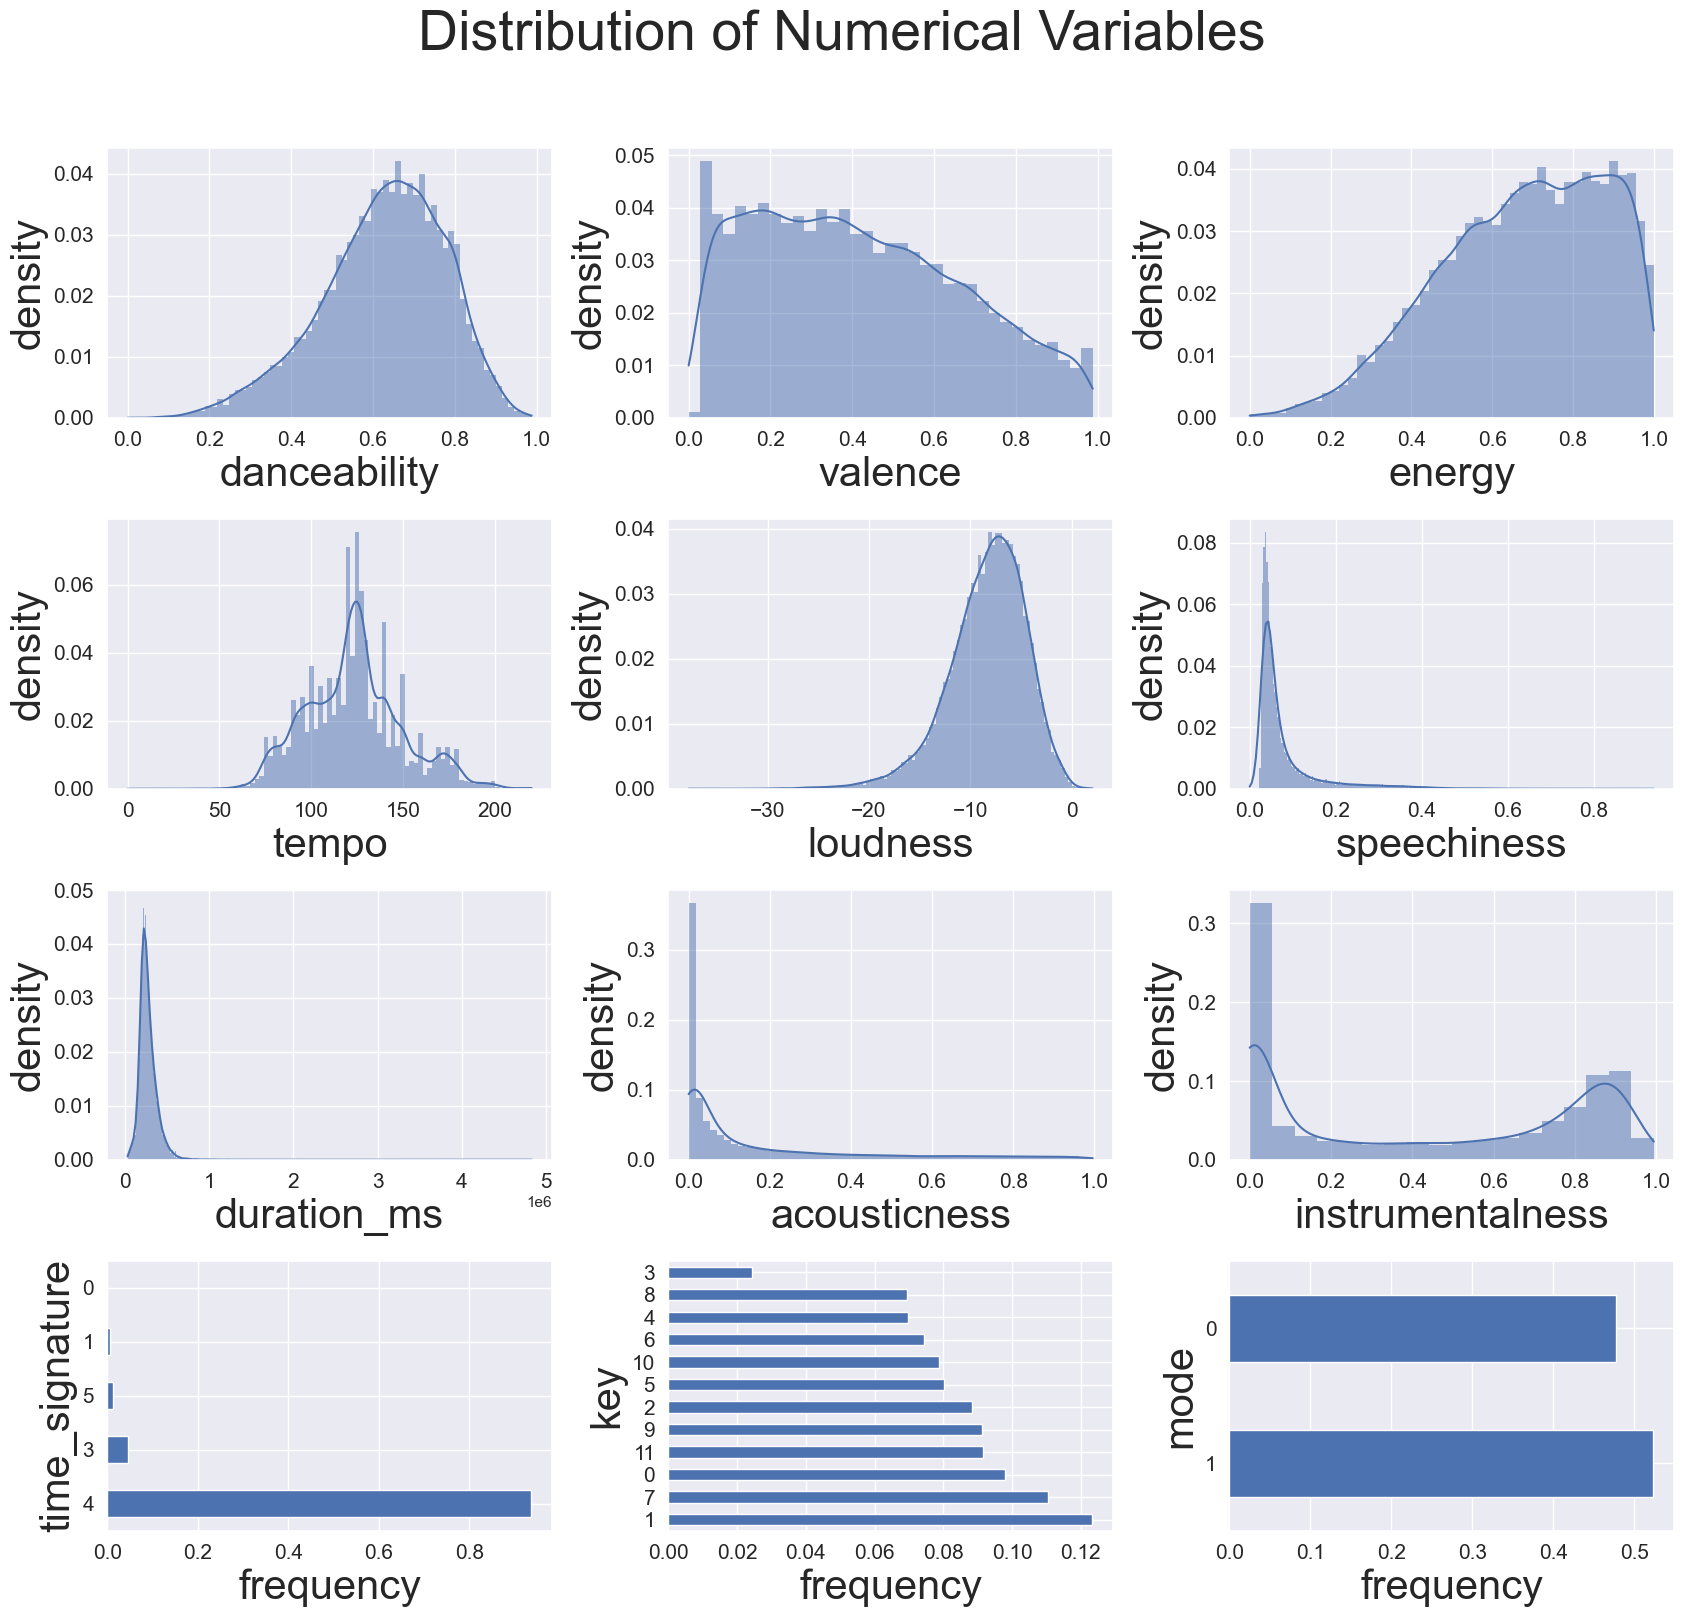

In [7]:
continuous_cols = ['danceability', 'valence', 'energy', 'tempo',
       'loudness', 'speechiness', 'duration_ms',
       'acousticness', 'instrumentalness'] # 9
discrete_cols = ['time_signature', 'key', 'mode']
n_rows=4
n_cols=3
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols,figsize=(17, 17))
for i, column in enumerate(continuous_cols):
    sns.histplot(df[column],ax=axes[i//n_cols,i%n_cols],kde=True, stat="probability", linewidth=0)
    axes[i//n_cols,i%n_cols].set_xlabel(column,fontsize=30)
    axes[i//n_cols,i%n_cols].set_ylabel("density",fontsize=30)
    axes[i//n_cols,i%n_cols].tick_params(axis='both', labelsize=15)
for i, column in enumerate(discrete_cols):
    ax=axes[i//n_cols+3,i%n_cols]
    df[column].value_counts(normalize=True).plot.barh(ax=ax)
    ax.set_xlabel("frequency",fontsize=30)
    ax.set_ylabel(column,fontsize=30)
    ax.tick_params(axis='both', labelsize=15)
fig.suptitle("Distribution of Numerical Variables",fontsize=40)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
fig.savefig("numerical.png")

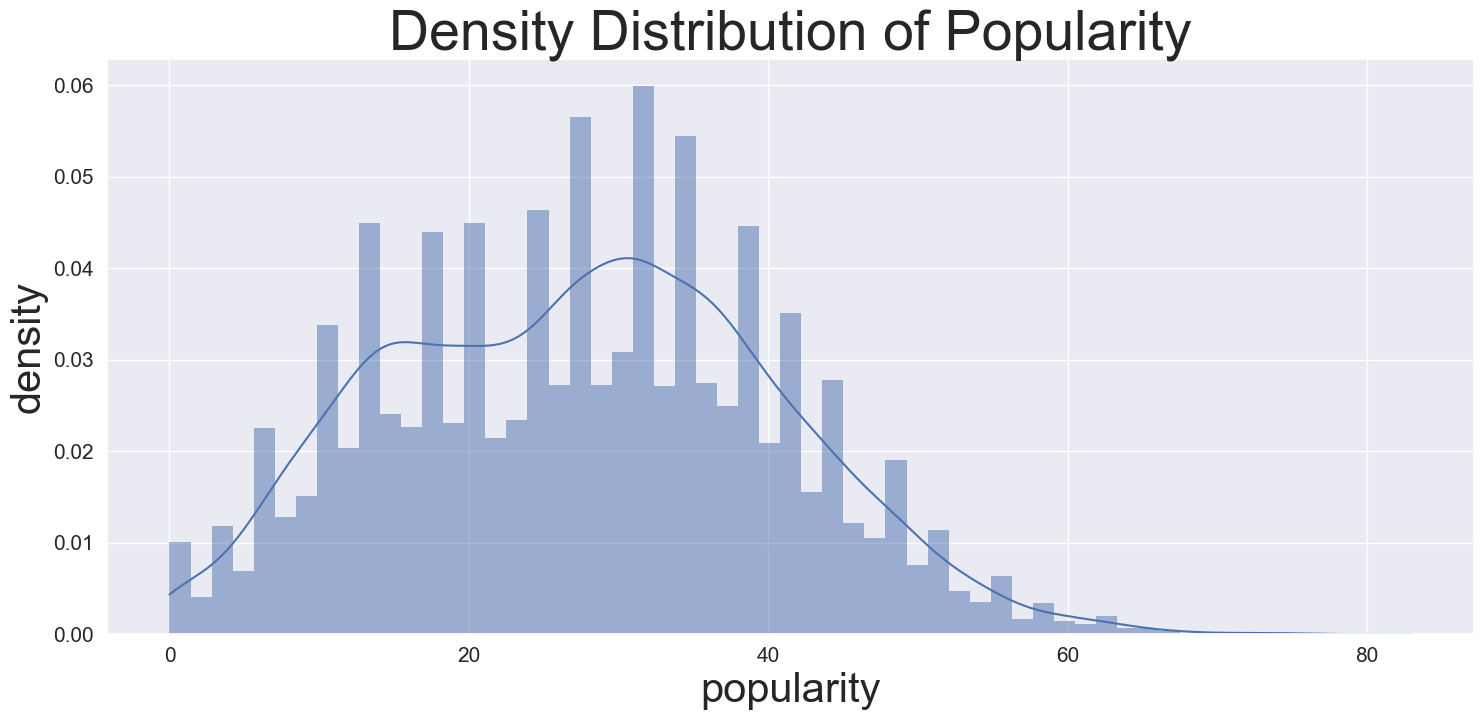

In [8]:
fig, axes = plt.subplots(figsize=(15, 8))
sns.histplot(df['popularity'],kde=True, stat="probability", linewidth=0)
plt.xlabel("popularity",fontsize=30)
plt.ylabel("density",fontsize=30)
plt.title("Density Distribution of Popularity",fontsize=40)
axes.tick_params(axis='both', labelsize=15)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
fig.savefig("dist.png")

## 2.2. Feature Encoding

Next, we encode two categorical features, `type_release` and `collaboration`, into discrete values for future analysis. The column `collaboration` takes two values, Y or N, so we encode it with binary number 0 or 1. The column `type_release` takes three unique values, 'single', 'album', or 'compilation'. Since these values do not attain ordinal attribute, we encode it using one-hot encoding.

In [9]:
display(pd.DataFrame(df["type_release"].value_counts()))
print("\n")
display(pd.DataFrame(df["collaboration"].value_counts()))

type_release
album               14736
single               6200
compilation          1064

collaboration
N          16129
Y           5871

In [10]:
# encode "type_release", note that "compilation"=0 and "single"=0 indicates "album"=1
enc = OneHotEncoder(drop='first', dtype=int)
enc.fit(df[["type_release"]])
df[['compilation','single']] = enc.transform(df[["type_release"]]).toarray()
# encode "collaboration"
df["collaboration"] = df["collaboration"].map({"Y":1, "N":0})
df.head()

artist_name              track_name                track_id type_release  \
0  Emancipator            Rappahannock  3D8AeuoC0w5cK7Kt7p3KQf        album   
1  Blue States   Protect Me Everywhere  1TpdbH4W8aqx1CZqu6EGFH        album   
2     Four Tet                Memories  0QIyJvZOkzMFLJb6mTLFUM        album   
3       Lookas  On My Own - ZAXX Remix  13Z9Bzr4Qrez0g2lOoBZ9B       single   
4     Redlight               Get Wavey  23r57CEuyNSM4ojNa03ei6        album   

   collaboration  danceability  valence  energy    tempo  key  ...  loudness  \
0              0         0.747   0.4060   0.541   90.024    9  ...    -9.374   
1              0         0.435   0.2360   0.770  155.025    0  ...    -6.194   
2              0         0.393   0.0391   0.393  128.004   11  ...   -14.891   
3              1         0.549   0.0681   0.793  134.971    4  ...    -2.905   
4              0         0.654   0.9440   0.933  129.986    8  ...    -6.088   

   time_signature  speechiness  duration_ms  acousticness  instrumentalness  \
0               4       0.0548       314293      0.493000          0.918000   
1               4       0.0339       212853      0.004570          0.880000   
2               4       0.0388       197904      0.762000          0.866000   
3               4       0.0389       238222      0.004510          0.000013   
4               4       0.0427       280753      0.000521          0.412000   

   release_date popularity  compilation  single  
0    2017-11-17         31            0       0  
1    2016-09-09         27            0       0  
2    2017-09-29         31            0       0  
3    2018-07-11         36            0       1  
4    2018-11-02         25            0       0  

[5 rows x 21 columns]

## 2.3. Bivariate Exploration 

In [11]:
artist_cnt = df.artist_name.value_counts()

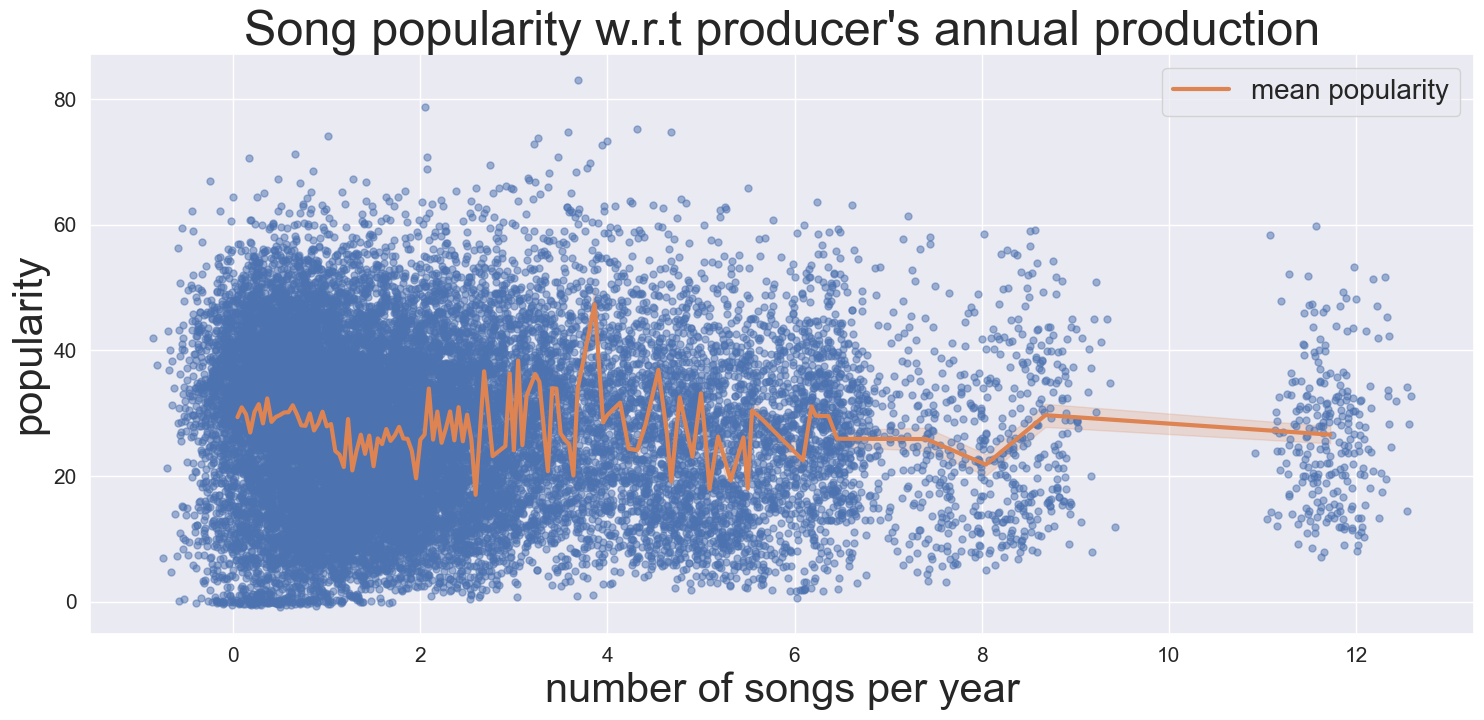

In [12]:
# composers who publish more have higher popularity?
df_count = pd.DataFrame({"artists":artist_cnt.index,"count":artist_cnt.values})
df_plot = pd.DataFrame({"artists":df["artist_name"],
                        "popularity":df["popularity"]})
df_plot = df_plot.merge(df_count,how='left')
df_plot["count"] = df_plot["count"]/22
n = len(df_plot)
fig, axes = plt.subplots(figsize=(15,8))
count_jittered = df_plot["count"] + np.random.normal(0, 0.3, n)
popularity_jittered = df_plot["popularity"] + np.random.normal(0, 0.3, n)
plt.plot(count_jittered, popularity_jittered, marker='o', linestyle='none', markersize=5, alpha=0.5)
sns.lineplot(data=df_plot, x="count", y="popularity",linewidth=3,label="mean popularity")
plt.xlabel("number of songs per year",fontsize=30)
plt.ylabel("popularity",fontsize=30)
plt.legend(fontsize=20)
plt.title("Song popularity w.r.t producer's annual production",fontsize=35)
axes.tick_params(axis='both', labelsize=15)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
fig.savefig("productivity.png")

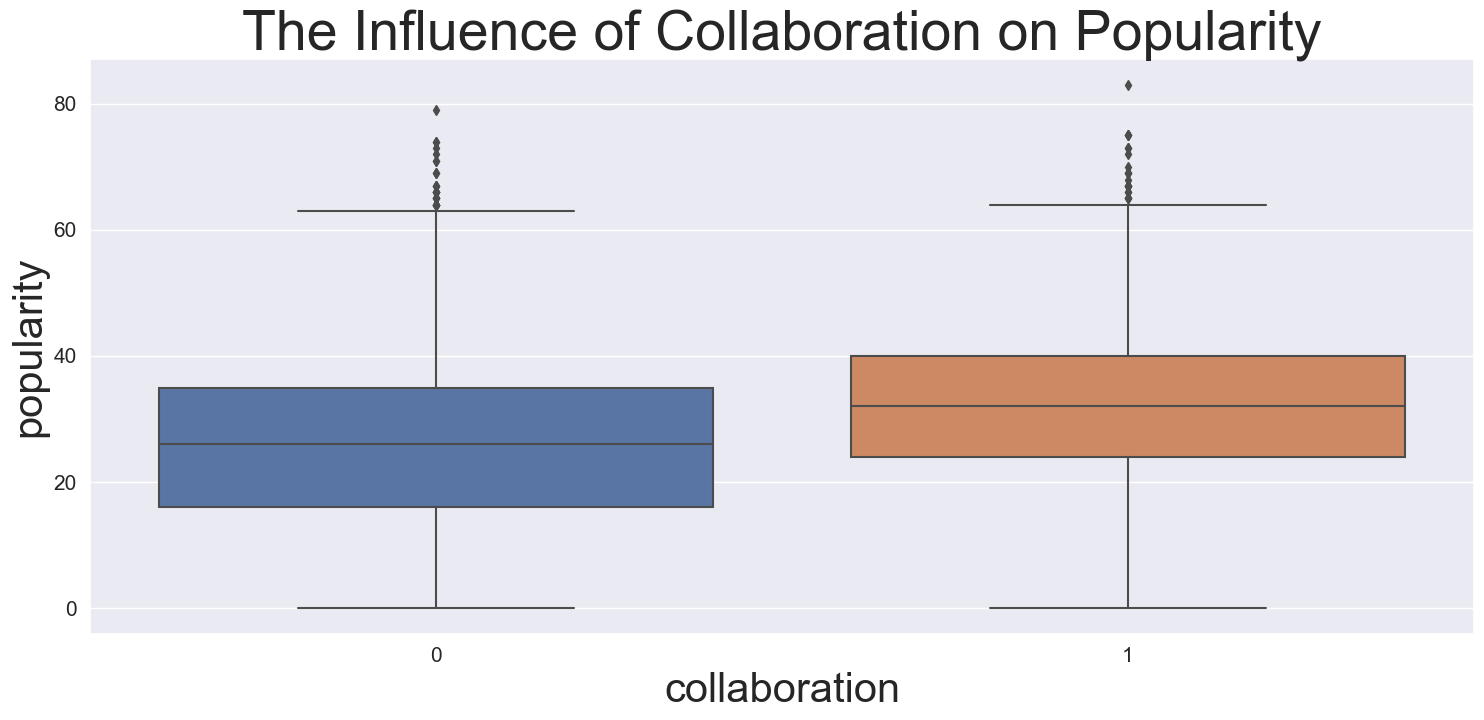

In [13]:
fig, axes = plt.subplots(figsize=(15, 8))
sns.boxplot(x='collaboration', y='popularity', data=df)
axes.set_xlabel('collaboration',fontsize=30)
axes.set_ylabel('popularity',fontsize=30)
axes.set_title("The Influence of Collaboration on Popularity",fontsize=40)
axes.tick_params(axis='both', labelsize=15)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
fig.savefig("collab.png")

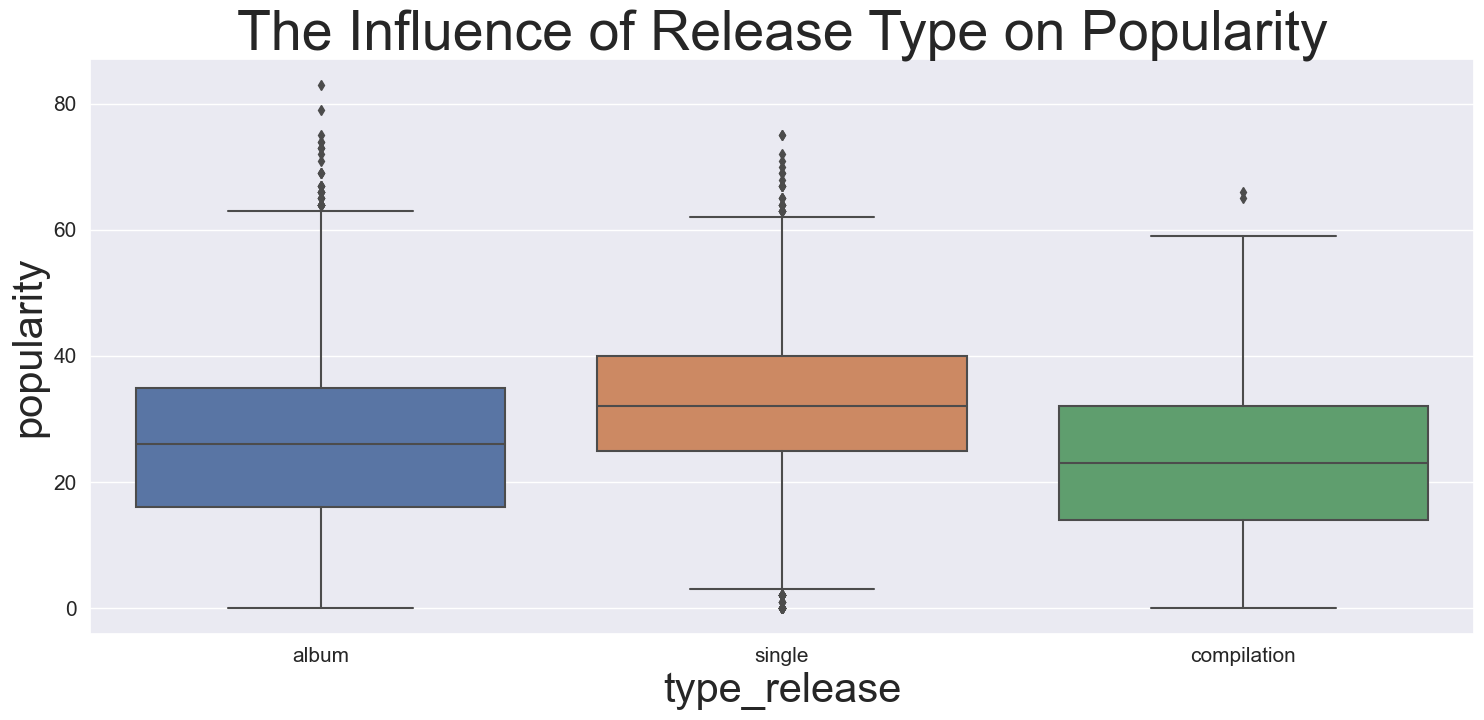

In [14]:
fig, axes = plt.subplots(figsize=(15, 8))
sns.boxplot(x='type_release', y='popularity', data=df)
axes.set_xlabel('type_release',fontsize=30)
axes.set_ylabel('popularity',fontsize=30)
axes.set_title("The Influence of Release Type on Popularity",fontsize=40)
axes.tick_params(axis='both', labelsize=15)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
fig.savefig("type_release.png")

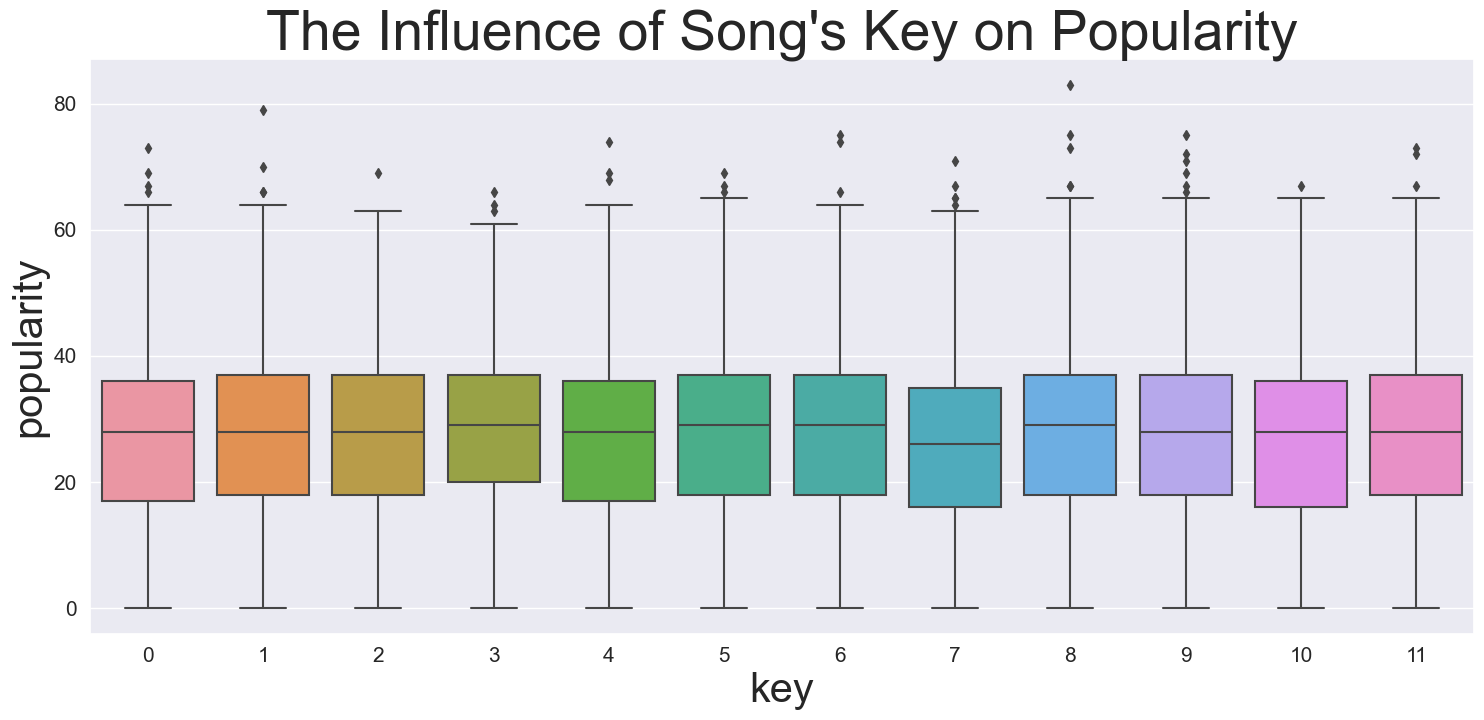

In [15]:
fig, axes = plt.subplots(figsize=(15, 8))
sns.boxplot(x='key', y='popularity', data=df)
axes.set_xlabel('key',fontsize=30)
axes.set_ylabel('popularity',fontsize=30)
axes.set_title("The Influence of Song's Key on Popularity",fontsize=40)
axes.tick_params(axis='both', labelsize=15)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
fig.savefig("key.png")

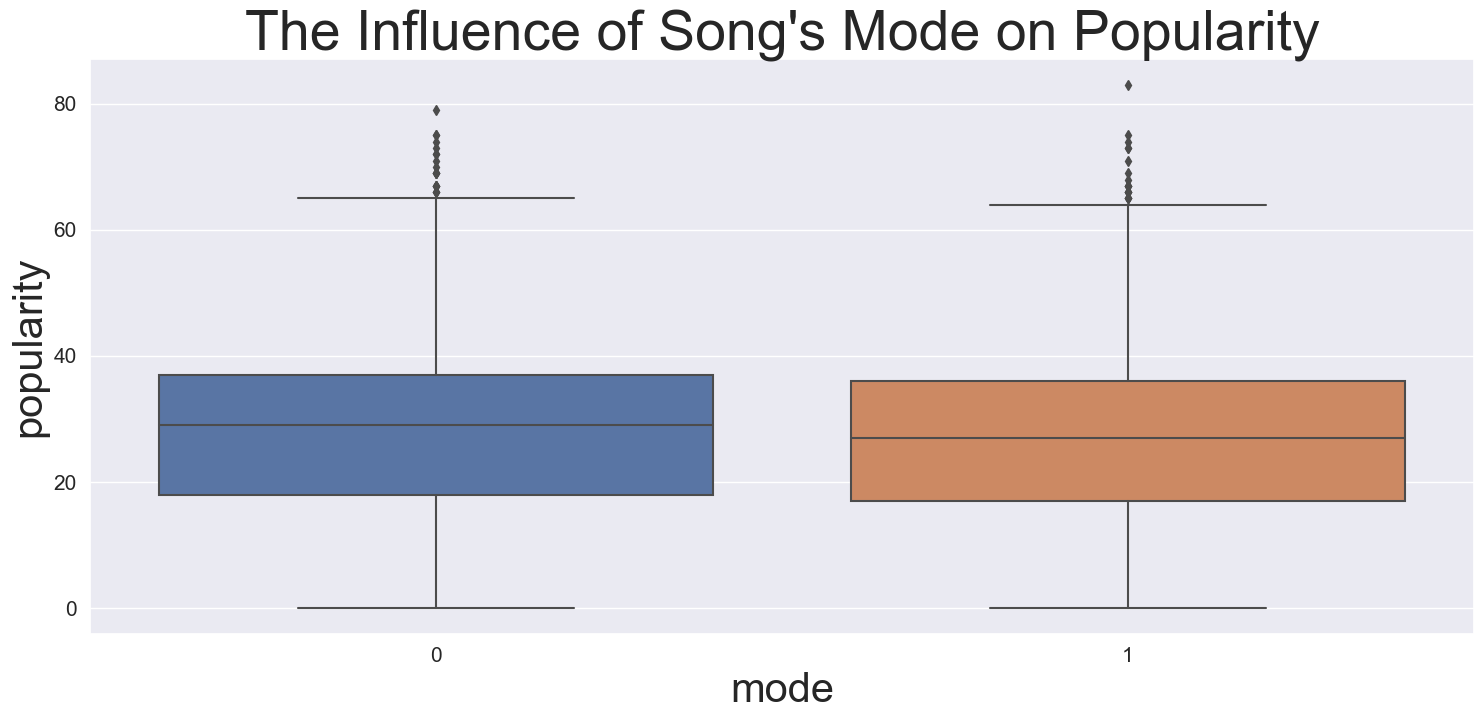

In [16]:
fig, axes = plt.subplots(figsize=(15, 8))
sns.boxplot(x='mode', y='popularity', data=df)
axes.set_xlabel('mode',fontsize=30)
axes.set_ylabel('popularity',fontsize=30)
axes.set_title("The Influence of Song's Mode on Popularity",fontsize=40)
axes.tick_params(axis='both', labelsize=15)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
fig.savefig("mode.png")

To see the relationship between song's popularity and the year of release, we build a new feature `year` based on `release_date`.

In [17]:
df["year"] = pd.DatetimeIndex(df['release_date']).year
df.head()

artist_name              track_name                track_id type_release  \
0  Emancipator            Rappahannock  3D8AeuoC0w5cK7Kt7p3KQf        album   
1  Blue States   Protect Me Everywhere  1TpdbH4W8aqx1CZqu6EGFH        album   
2     Four Tet                Memories  0QIyJvZOkzMFLJb6mTLFUM        album   
3       Lookas  On My Own - ZAXX Remix  13Z9Bzr4Qrez0g2lOoBZ9B       single   
4     Redlight               Get Wavey  23r57CEuyNSM4ojNa03ei6        album   

   collaboration  danceability  valence  energy    tempo  key  ...  \
0              0         0.747   0.4060   0.541   90.024    9  ...   
1              0         0.435   0.2360   0.770  155.025    0  ...   
2              0         0.393   0.0391   0.393  128.004   11  ...   
3              1         0.549   0.0681   0.793  134.971    4  ...   
4              0         0.654   0.9440   0.933  129.986    8  ...   

   time_signature  speechiness  duration_ms  acousticness  instrumentalness  \
0               4       0.0548       314293      0.493000          0.918000   
1               4       0.0339       212853      0.004570          0.880000   
2               4       0.0388       197904      0.762000          0.866000   
3               4       0.0389       238222      0.004510          0.000013   
4               4       0.0427       280753      0.000521          0.412000   

   release_date  popularity compilation  single  year  
0    2017-11-17          31           0       0  2017  
1    2016-09-09          27           0       0  2016  
2    2017-09-29          31           0       0  2017  
3    2018-07-11          36           0       1  2018  
4    2018-11-02          25           0       0  2018  

[5 rows x 22 columns]

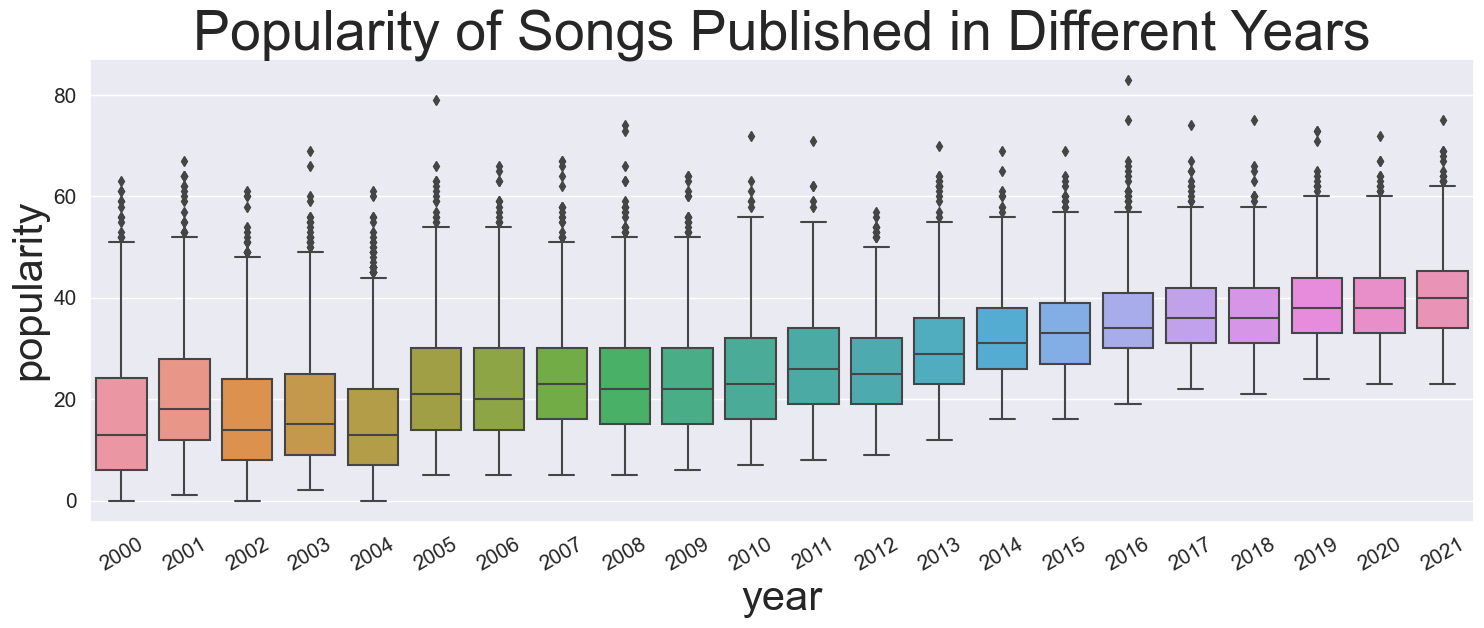

In [18]:
fig, axes = plt.subplots(figsize=(15,7))
sns.boxplot(data=df,x="year",y="popularity")
plt.xlabel("year",fontsize=30)
plt.ylabel("popularity",fontsize=30)
plt.title("Popularity of Songs Published in Different Years",fontsize=40)
axes.tick_params(axis='both', labelsize=15)
plt.xticks(rotation=30)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
fig.savefig("year.png")

## 2.4. Multicollinearity

/var/folders/1p/m1pcbv7x2_10_7l__x87z_kh0000gn/T/ipykernel_20534/377974476.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot = True,linewidths=3, cmap='rainbow',


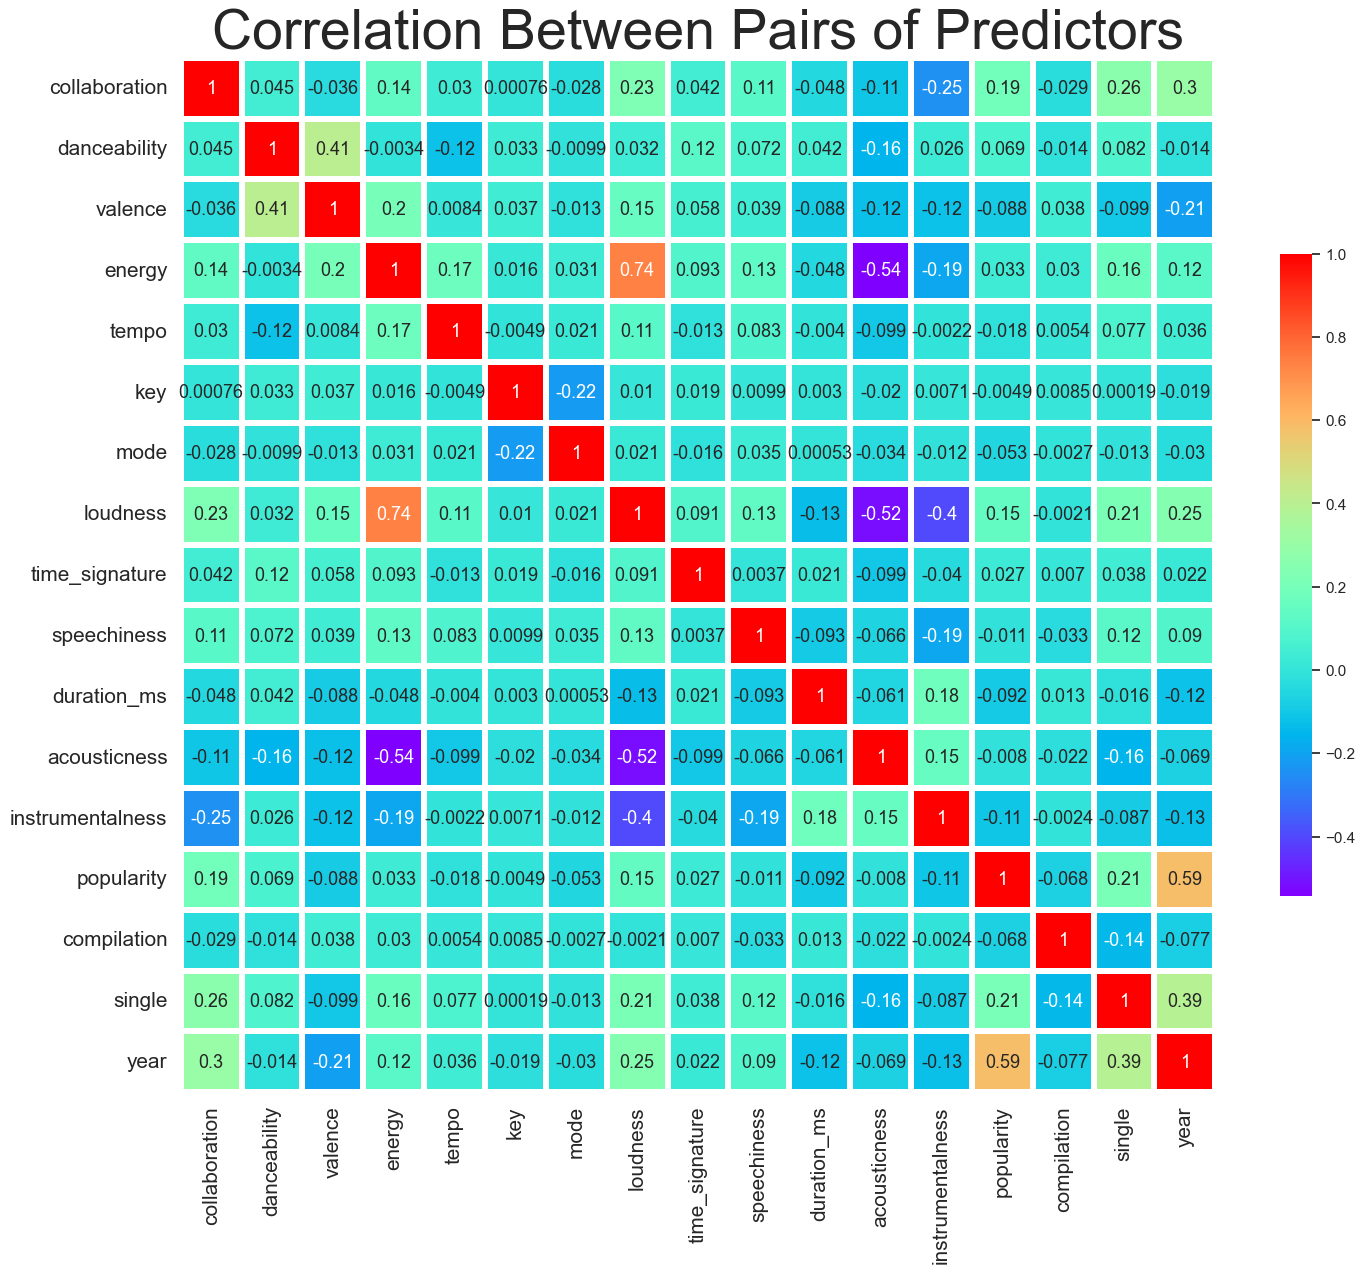

In [19]:
fig, axes = plt.subplots(figsize=(15,15))
sns.heatmap(df.corr(),annot = True,linewidths=3, cmap='rainbow',
            annot_kws={"fontsize":13},cbar_kws={"shrink": 0.5},square=True)
plt.title("Correlation Between Pairs of Predictors",fontsize=40)
axes.tick_params(axis='both', labelsize=15)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
fig.savefig("heatmap.png")

# 3. Modeling

## 3.1. Feature Scaling


In [20]:
cols_to_scale = ['danceability', 'valence', 'energy', 'tempo',
                 'loudness', 'speechiness', 'duration_ms',
                 'acousticness', 'instrumentalness','key','time_signature']

In [21]:
scaler = StandardScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])
# we standardize "year" feature separately
year_scaler = StandardScaler().fit(df[['year']])
df['year'] = year_scaler.transform(df[['year']])
df.head()

artist_name              track_name                track_id type_release  \
0  Emancipator            Rappahannock  3D8AeuoC0w5cK7Kt7p3KQf        album   
1  Blue States   Protect Me Everywhere  1TpdbH4W8aqx1CZqu6EGFH        album   
2     Four Tet                Memories  0QIyJvZOkzMFLJb6mTLFUM        album   
3       Lookas  On My Own - ZAXX Remix  13Z9Bzr4Qrez0g2lOoBZ9B       single   
4     Redlight               Get Wavey  23r57CEuyNSM4ojNa03ei6        album   

   collaboration  danceability   valence    energy     tempo       key  ...  \
0              0      0.806292 -0.036479 -0.663134 -1.280001  0.983662  ...   
1              0     -1.262752 -0.713069  0.459500  1.210382 -1.507672  ...   
2              0     -1.541277 -1.496720 -1.388680  0.175126  1.537291  ...   
3              1     -0.506755 -1.381301  0.572254  0.442053 -0.400413  ...   
4              0      0.189558  2.104729  1.258581  0.251063  0.706847  ...   

   time_signature  speechiness  duration_ms  acousticness  instrumentalness  \
0        0.158324    -0.313705     0.312159      1.231555          1.302826   
1        0.158324    -0.563549    -0.462965     -0.682123          1.201356   
2        0.158324    -0.504973    -0.577193      2.285503          1.163972   
3        0.158324    -0.503778    -0.269115     -0.682358         -1.148451   
4        0.158324    -0.458352     0.055873     -0.697987         -0.048332   

   release_date  popularity compilation  single      year  
0    2017-11-17          31           0       0  1.024544  
1    2016-09-09          27           0       0  0.866921  
2    2017-09-29          31           0       0  1.024544  
3    2018-07-11          36           0       1  1.182166  
4    2018-11-02          25           0       0  1.182166  

[5 rows x 22 columns]

## 3.2. Baseline Model

We built a vanilla linear regression as the basline model.

In [22]:
predictors = ['collaboration', 'danceability', 'valence', 'energy', 'tempo', 'key',
       'mode', 'loudness', 'time_signature', 'speechiness', 'duration_ms',
       'acousticness', 'instrumentalness', 'compilation',
       'single']
X = df[predictors]
y = df['popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=109)
X_train.shape, X_test.shape

((17600, 15), (4400, 15))

In [23]:
lr = LinearRegression(fit_intercept=True).fit(X_train, y_train)
training_mse = mean_squared_error(y_train, lr.predict(X_train))
test_mse = mean_squared_error(y_test, lr.predict(X_test))
training_r2 = lr.score(X_train, y_train)
test_r2 = lr.score(X_test, y_test)
results = [{
    'model': "Linear Regression (Baseline)",
    'train_mse': training_mse,
    'train_R-squared': training_r2, 
    'test_mse': test_mse,
    'test_R-squared': test_r2
}]

In [24]:
print(
    "The linear regression model trained on the "
    "training set, achieves the following MSE scores:"
    "\n\n\ttrain\t{:.4f}\n\ttest\t{:.4f}".format(
        training_mse,
        test_mse,
    )
)
print(
    "The linear regression model trained on the "
    "training set, achieves the following R-squared scores:"
    "\n\n\ttrain\t{:.4f}\n\ttest\t{:.4f}".format(
        training_r2,
        test_r2,
    )
)

The linear regression model trained on the training set, achieves the following MSE scores:

	train	148.3425
	test	156.4662
The linear regression model trained on the training set, achieves the following R-squared scores:

	train	0.1174
	test	0.0841


In [25]:
print(
    "The intercept and coefficients for the 'baseline' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", np.array(lr.intercept_).flatten()[0]
    )
)

for predictor, coef in zip(predictors, lr.coef_.flatten()):
    print("\t{:<20}{:.4f}".format(predictor, coef))

The intercept and coefficients for the 'baseline' model are:

	intercept           26.2785
	collaboration       3.4154
	danceability        1.5685
	valence             -1.7073
	energy              -0.9576
	tempo               -0.1362
	key                 -0.1462
	mode                -1.1978
	loudness            2.5342
	time_signature      0.0928
	speechiness         -0.8567
	duration_ms         -0.8208
	acousticness        1.1062
	instrumentalness    -0.3955
	compilation         -2.5433
	single              4.2088


## 3.3. Ridge Regression

### 3.3.1. Same Predictors as Baseline

In [26]:
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
fit_intercept = True
max_iter = int(1e+6)

In [27]:
ridge = RidgeCV(fit_intercept=fit_intercept, alphas=alphas, cv=5).fit(X_train, y_train)
best_ridge_alpha = ridge.alpha_

In [28]:
best_ridge = Ridge(alpha=best_ridge_alpha, fit_intercept=fit_intercept, max_iter=max_iter).fit(X_train, y_train)
training_mse = mean_squared_error(y_train, best_ridge.predict(X_train))
test_mse = mean_squared_error(y_test, best_ridge.predict(X_test))
training_acc = best_ridge.score(X_train, y_train)
test_acc = best_ridge.score(X_test, y_test)

In [29]:
print(
    "The Ridge regression (alpha={}) model trained on the "
    "training set, achieves the following MSE scores:"
    "\n\n\ttrain\t{:.4f}\n\ttest\t{:.4f}".format(
        best_ridge_alpha,
        training_mse,
        test_mse,
    )
)
print(
    "The Ridge regression (alpha={}) model trained on the "
    "training set, achieves the following R-squared scores:"
    "\n\n\ttrain\t{:.4f}\n\ttest\t{:.4f}".format(
        best_ridge_alpha,
        training_acc,
        test_acc,
    )
)

The Ridge regression (alpha=0.1) model trained on the training set, achieves the following MSE scores:

	train	148.3425
	test	156.4661
The Ridge regression (alpha=0.1) model trained on the training set, achieves the following R-squared scores:

	train	0.1174
	test	0.0841


In [30]:
print(
    "The intercept and coefficients for the 'best_ridge' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", np.array(best_ridge.intercept_).flatten()[0]
    )
)

for predictor, coef in zip(predictors, best_ridge.coef_.flatten()):
    print("\t{:<20}{:.4f}".format(predictor, coef))

The intercept and coefficients for the 'best_ridge' model are:

	intercept           26.2785
	collaboration       3.4154
	danceability        1.5685
	valence             -1.7073
	energy              -0.9576
	tempo               -0.1362
	key                 -0.1462
	mode                -1.1977
	loudness            2.5341
	time_signature      0.0929
	speechiness         -0.8567
	duration_ms         -0.8208
	acousticness        1.1062
	instrumentalness    -0.3955
	compilation         -2.5430
	single              4.2087


### 3.3.2. Add Year Predictor

In [31]:
predictors = ['collaboration', 'danceability', 'valence', 'energy', 'tempo', 'key',
       'mode', 'loudness', 'time_signature', 'speechiness', 'duration_ms',
       'acousticness', 'instrumentalness', 'compilation', 'single', 
       'year']
X = df[predictors]
y = df['popularity']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=109)

In [32]:
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
fit_intercept = True
max_iter = int(1e+6)

In [33]:
ridge = RidgeCV(fit_intercept=fit_intercept, alphas=alphas, cv=5).fit(X_train, y_train)
best_ridge_alpha = ridge.alpha_

In [34]:
best_ridge = Ridge(alpha=best_ridge_alpha, fit_intercept=fit_intercept, max_iter=max_iter).fit(X_train, y_train)
training_mse = mean_squared_error(y_train, best_ridge.predict(X_train))
test_mse = mean_squared_error(y_test, best_ridge.predict(X_test))
training_r2 = best_ridge.score(X_train, y_train)
test_r2 = best_ridge.score(X_test, y_test)
results.append({
    'model': "Ridge Regression",
    'train_mse': training_mse,
    'train_R-squared': training_r2, 
    'test_mse': test_mse,
    'test_R-squared': test_r2
})

In [35]:
print(
    "The Ridge regression (alpha={}) model trained on the "
    "training set, achieves the following MSE scores:"
    "\n\n\ttrain\t{:.4f}\n\ttest\t{:.4f}".format(
        best_ridge_alpha,
        training_mse,
        test_mse,
    )
)
print(
    "The Ridge regression (alpha={}) model trained on the "
    "training set, achieves the following R-squared scores:"
    "\n\n\ttrain\t{:.4f}\n\ttest\t{:.4f}".format(
        best_ridge_alpha,
        training_r2,
        test_r2,
    )
)

The Ridge regression (alpha=0.1) model trained on the training set, achieves the following MSE scores:

	train	106.8963
	test	110.5702
The Ridge regression (alpha=0.1) model trained on the training set, achieves the following R-squared scores:

	train	0.3640
	test	0.3528


In [36]:
print(
    "The intercept and coefficients for the 'best_ridge' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", np.array(best_ridge.intercept_).flatten()[0]
    )
)

for predictor, coef in zip(predictors, best_ridge.coef_.flatten()):
    print("\t{:<20}{:.4f}".format(predictor, coef))

The intercept and coefficients for the 'best_ridge' model are:

	intercept           28.1455
	collaboration       0.4448
	danceability        1.1965
	valence             -0.0302
	energy              -0.5182
	tempo               -0.1984
	key                 0.0316
	mode                -0.6653
	loudness            0.6226
	time_signature      0.0915
	speechiness         -0.9720
	duration_ms         -0.2256
	acousticness        0.5653
	instrumentalness    -0.4489
	compilation         -1.7009
	single              -0.6495
	year                7.5925


## 3.4. Lasso Regression

In [37]:
alphas = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]
fit_intercept = True
max_iter = int(1e+6)

In [38]:
lasso = LassoCV(fit_intercept=fit_intercept, alphas=alphas, max_iter=max_iter, cv=5, random_state=109).fit(X_train, y_train)
best_lasso_alpha = lasso.alpha_

In [39]:
best_lasso = Lasso(fit_intercept=fit_intercept, max_iter=max_iter, alpha=best_lasso_alpha).fit(X_train, y_train)
training_mse = mean_squared_error(y_train, best_lasso.predict(X_train))
test_mse = mean_squared_error(y_test, best_lasso.predict(X_test))
training_r2 = best_lasso.score(X_train, y_train)
test_r2 = best_lasso.score(X_test, y_test)
results.append({
    'model': "Lasso Regression",
    'train_mse': training_mse,
    'train_R-squared': training_r2, 
    'test_mse': test_mse,
    'test_R-squared': test_r2
})

In [40]:
print(
    "The Lasso regression (alpha={}) model trained on the "
    "training set, achieves the following MSE scores:"
    "\n\n\ttrain\t{:.4f}\n\ttest\t{:.4f}".format(
        best_lasso_alpha,
        training_mse,
        test_mse,
    )
)
print(
    "The Lasso regression (alpha={}) model trained on the "
    "training set, achieves the following R-squared scores:"
    "\n\n\ttrain\t{:.4f}\n\ttest\t{:.4f}".format(
        best_lasso_alpha,
        training_r2,
        test_r2,
    )
)

The Lasso regression (alpha=0.01) model trained on the training set, achieves the following MSE scores:

	train	106.9021
	test	110.5771
The Lasso regression (alpha=0.01) model trained on the training set, achieves the following R-squared scores:

	train	0.3640
	test	0.3527


In [41]:
print(
    "The intercept and coefficients for the 'best_lasso' model are:"
    "\n\n\t{:<20}{:.4f}".format(
        "intercept", np.array(best_lasso.intercept_).flatten()[0]
    )
)

for predictor, coef in zip(predictors, best_lasso.coef_.flatten()):
    print("\t{:<20}{:.4f}".format(predictor, coef))

The intercept and coefficients for the 'best_lasso' model are:

	intercept           28.1035
	collaboration       0.3881
	danceability        1.1762
	valence             -0.0103
	energy              -0.4996
	tempo               -0.1956
	key                 0.0244
	mode                -0.6307
	loudness            0.5876
	time_signature      0.0824
	speechiness         -0.9600
	duration_ms         -0.2189
	acousticness        0.5519
	instrumentalness    -0.4459
	compilation         -1.4640
	single              -0.5525
	year                7.5871


## 3.5. Generalized Linear Model

In [42]:
glm = PoissonRegressor(fit_intercept=True).fit(X_train, y_train)
training_mse = mean_squared_error(y_train, glm.predict(X_train))
test_mse = mean_squared_error(y_test, glm.predict(X_test))
training_r2 = glm.score(X_train, y_train)
test_r2 = glm.score(X_test, y_test)

In [43]:
results.append({
    'model': "Poisson Regression",
    'train_mse': training_mse,
    'train_R-squared': training_r2, 
    'test_mse': test_mse,
    'test_R-squared': test_r2
})

In [44]:
print(
    "The generalized linear model with poisson distribution trained on the "
    "training set, achieves the following MSE scores:"
    "\n\n\ttrain\t{:.4f}\n\ttest\t{:.4f}".format(
        training_mse,
        test_mse,
    )
)
print(
    "The generalized linear model with poisson distribution trained on the "
    "training set, achieves the following R-squared scores:"
    "\n\n\ttrain\t{:.4f}\n\ttest\t{:.4f}".format(
        training_r2,
        test_r2,
    )
)

The generalized linear model with poisson distribution trained on the training set, achieves the following MSE scores:

	train	106.8378
	test	110.2366
The generalized linear model with poisson distribution trained on the training set, achieves the following R-squared scores:

	train	0.3321
	test	0.3224


## 3.6. Gradient Boosting

In [45]:
# PLEASE NOTICE THIS CELL TAKES SOME MINIUTES TO FINISH!
# Note that RandomizedSearchCV probably returns different results each time
params = {'max_depth': [1,2,3,4,5],
          'n_estimators':[100,200,300],
          'learning_rate':[.01,.05,.1]
          }
reg = GradientBoostingRegressor()
grid_reg = RandomizedSearchCV(reg,param_distributions=params,cv=5,n_jobs=-1,verbose=3)
grid_reg.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [1, 2, 3, 4, 5],
                                        'n_estimators': [100, 200, 300]},
                   verbose=3)

In [46]:
# {'n_estimators': 300, 'max_depth': 3, 'learning_rate': 0.05}
best_params = grid_reg.best_params_
best_params

{'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.05}

In [47]:
reg = GradientBoostingRegressor(max_depth=3,n_estimators=300,learning_rate=.05).fit(X_train,y_train)
training_mse = mean_squared_error(y_train, reg.predict(X_train))
test_mse = mean_squared_error(y_test, reg.predict(X_test))
training_r2 = reg.score(X_train, y_train)
test_r2 = reg.score(X_test, y_test)
results.append({
    'model': "Gradient Boosting",
    'train_mse': training_mse,
    'train_R-squared': training_r2, 
    'test_mse': test_mse,
    'test_R-squared': test_r2
})

In [48]:
print(
    "The Gradient boosting ({}) model trained on the "
    "training set, achieves the following MSE scores:"
    "\n\n\ttrain\t{:.4f}\n\ttest\t{:.4f}".format(
        {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05},
        training_mse,
        test_mse,
    )
)
print(
    "The Gradient boosting ({}) model trained on the "
    "training set, achieves the following R-squared scores:"
    "\n\n\ttrain\t{:.4f}\n\ttest\t{:.4f}".format(
        {'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05},
        training_r2,
        test_r2,
    )
)

The Gradient boosting ({'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05}) model trained on the training set, achieves the following MSE scores:

	train	93.7936
	test	102.7979
The Gradient boosting ({'n_estimators': 200, 'max_depth': 5, 'learning_rate': 0.05}) model trained on the training set, achieves the following R-squared scores:

	train	0.4420
	test	0.3983


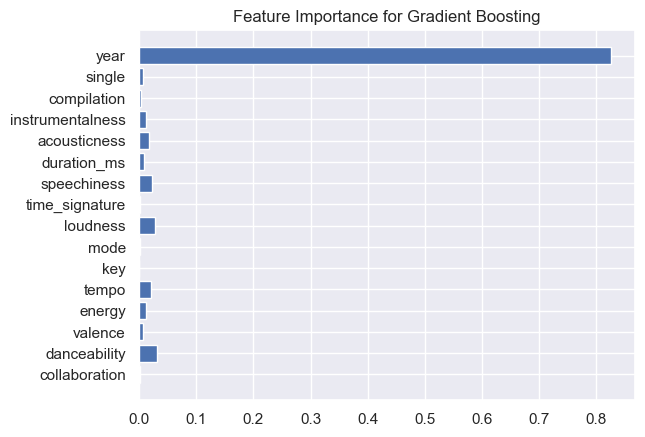

In [49]:
plt.barh(reg.feature_names_in_, reg.feature_importances_)
plt.title('Feature Importance for Gradient Boosting')
plt.show();

## 3.7. XGBoost

In [ ]:
# PLEASE NOTICE THIS CELL TAKES SOME MINIUTES TO FINISH!
params = {'max_depth': [1,2,3,4,5],
          'n_estimators':[100,200,300],
          'learning_rate':[.01,.05,.1],
          'reg_alpha':[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
          'reg_alpha':[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
          }
xgb_reg = xgb.XGBRegressor()
grid_xgb = RandomizedSearchCV(xgb_reg,param_distributions=params,cv=5,n_jobs=-1,verbose=3)
grid_xgb.fit(X_train,y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[01:48:22] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


RandomizedSearchCV(cv=5, estimator=XGBRegressor(), n_jobs=-1,
                   param_distributions={'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [1, 2, 3, 4, 5],
                                        'n_estimators': [100, 200, 300],
                                        'reg_alpha': [0.0, 0.1, 0.2, 0.3, 0.4,
                                                      0.5, 0.6, 0.7, 0.8, 0.9,
                                                      1.0]},
                   verbose=3)

In [ ]:
{'reg_alpha': 0.9, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.05}
best_params = grid_xgb.best_params_
best_params

{'reg_alpha': 0.0, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}

In [50]:
xgb_reg = xgb.XGBRegressor(reg_alpha=.9,n_estimators=100,max_depth=4,learning_rate=.05).fit(X_train,y_train)
training_mse = mean_squared_error(y_train, xgb_reg.predict(X_train))
test_mse = mean_squared_error(y_test, xgb_reg.predict(X_test))
training_r2 = xgb_reg.score(X_train, y_train)
test_r2 = xgb_reg.score(X_test, y_test)
results.append({
    'model': "XGBoost",
    'train_mse': training_mse,
    'train_R-squared': training_r2, 
    'test_mse': test_mse,
    'test_R-squared': test_r2
})

In [51]:
print(
    "The XGBoost ({}) model trained on the "
    "training set, achieves the following MSE scores:"
    "\n\n\ttrain\t{:.4f}\n\ttest\t{:.4f}".format(
        {'reg_alpha': 0.0, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1},
        training_mse,
        test_mse,
    )
)
print(
    "The XGBoost ({}) model trained on the "
    "training set, achieves the following R-squared scores:"
    "\n\n\ttrain\t{:.4f}\n\ttest\t{:.4f}".format(
        {'reg_alpha': 0.0, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1},
        training_r2,
        test_r2,
    )
)

The XGBoost ({'reg_alpha': 0.0, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}) model trained on the training set, achieves the following MSE scores:

	train	95.2442
	test	103.0790
The XGBoost ({'reg_alpha': 0.0, 'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}) model trained on the training set, achieves the following R-squared scores:

	train	0.4333
	test	0.3966


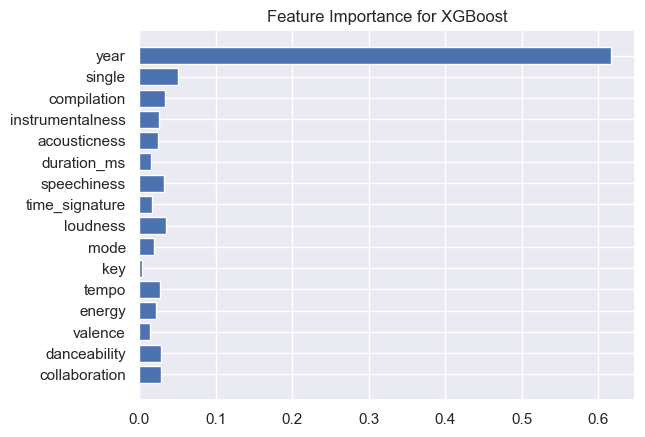

In [52]:
plt.barh(X_train.columns, xgb_reg.feature_importances_)
plt.title('Feature Importance for XGBoost')
plt.show();

## 3.8. Stacking

In [53]:
estimators = [
    ('lr', LinearRegression()),
    ('lasso', LassoCV()), 
    ('ridge', RidgeCV()),
    ('glm', PoissonRegressor()),
    ('boosting', GradientBoostingRegressor(max_depth=5))
]

stacked_reg = StackingRegressor(
    estimators=estimators, 
    final_estimator=LinearRegression()
)

In [54]:
stacked_reg.fit(X_train, y_train)
training_mse = mean_squared_error(y_train, stacked_reg.predict(X_train))
test_mse = mean_squared_error(y_test, stacked_reg.predict(X_test))
training_r2 = stacked_reg.score(X_train, y_train)
test_r2 = stacked_reg.score(X_test, y_test)

print(
    "The stacked model trained on the "
    "training set, achieves the following MSE scores:"
    "\n\n\ttrain\t{:.4f}\n\ttest\t{:.4f}".format(
        training_mse,
        test_mse,
    )
)
print(
    "The stacked model trained on the "
    "training set, achieves the following R-squared scores:"
    "\n\n\ttrain\t{:.4f}\n\ttest\t{:.4f}".format(
        training_r2,
        test_r2,
    )
)

The stacked model trained on the training set, achieves the following MSE scores:

	train	85.7734
	test	102.5020
The stacked model trained on the training set, achieves the following R-squared scores:

	train	0.4897
	test	0.4000


In [56]:
results.append({
    'model': "Stacking",
    'train_mse': training_mse,
    'train_R-squared': training_r2, 
    'test_mse': test_mse,
    'test_R-squared': test_r2
})

## 3.9. Tree Familiy

In [57]:
train_mse = []
test_mse = []
training_acc = []
test_acc = []

for depth in range(1,30):
    model = DecisionTreeClassifier(max_depth=depth)
    model.fit(X_train, y_train)
    train_mse.append(mean_squared_error(y_train, model.predict(X_train)))
    test_mse.append(mean_squared_error(y_test, model.predict(X_test)))
    training_acc.append(model.score(X_train, y_train))
    test_acc.append(model.score(X_test, y_test))

best_depth = test_mse.index(min(test_mse)) + 1
print(f"The minimum test MSE is {min(test_mse)} with depth {best_depth}")
best_train_mse = train_mse[best_depth - 1]
best_test_mse = test_mse[best_depth - 1]
best_training_acc = training_acc[best_depth - 1]
best_test_acc = test_acc[best_depth - 1]

print(
    "The single decision tree model with trained on the "
    "training set, achieves the following MSE scores:"
    "\n\n\ttrain\t{:.4f}\n\ttest\t{:.4f}".format(
        best_train_mse,
        best_test_mse,
    )
)
print(
    "The single decision tree model with trained on the "
    "training set, achieves the following R-squared scores:"
    "\n\n\ttrain\t{:.4f}\n\ttest\t{:.4f}".format(
        best_training_acc,
        best_test_acc,
    )
)

results.append({
    'model': "Single Best Decision Tree",
    'train_mse': best_train_mse,
    'train_R-squared': best_training_acc, 
    'test_mse': best_test_mse,
    'test_R-squared': best_test_acc
})

The minimum test MSE is 141.44931818181817 with depth 7
The single decision tree model with trained on the training set, achieves the following MSE scores:

	train	136.6363
	test	141.4493
The single decision tree model with trained on the training set, achieves the following R-squared scores:

	train	0.0822
	test	0.0461


In [58]:
n_estimators = 30

bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(max_depth=best_depth),n_estimators=n_estimators, random_state=109)
bagging.fit(X_train, y_train)
bagging_train_mse = mean_squared_error(y_train, bagging.predict(X_train))
bagging_test_mse = mean_squared_error(y_test, bagging.predict(X_test))
bagging_training_acc = bagging.score(X_train, y_train)
bagging_test_acc = bagging.score(X_test, y_test)

# print model results summary
print(
    "The bagging tree of max-depth {} trained on {} estimators "
    "full training set, achieves the following MSE:"
    "\n\n\ttrain MSE\t{:.4f}\n\tTEST MSE\t{:.4f}"
    "\n\n\ttrain R^2\t{:.4f}\n\tTEST R^2\t{:.4f}".format(
        best_depth,
        n_estimators,
        bagging_train_mse,
        bagging_test_mse,
        bagging_training_acc,
        bagging_test_acc,
    )
)

results.append({
    'model': "Bagging",
    'train_mse': bagging_train_mse,
    'train_R-squared': bagging_training_acc, 
    'test_mse': bagging_test_mse,
    'test_R-squared': bagging_test_acc
})

The bagging tree of max-depth 7 trained on 30 estimators full training set, achieves the following MSE:

	train MSE	136.4756
	TEST MSE	148.9134

	train R^2	0.1699
	TEST R^2	0.0507


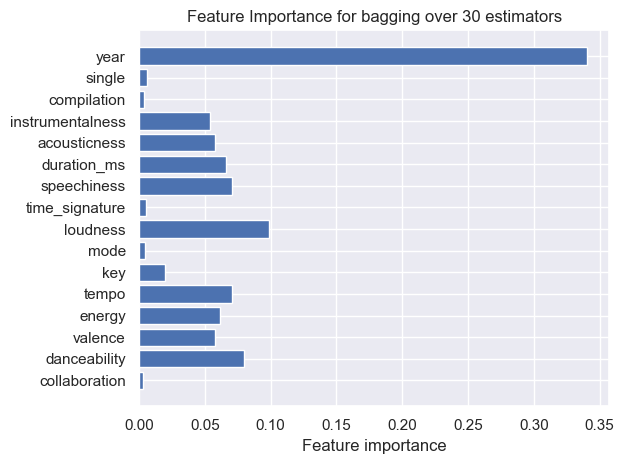

In [59]:
feature_importances = np.mean([base.feature_importances_ for base in bagging.estimators_], axis=0)
fig, ax = plt.subplots()
plt.barh(bagging.feature_names_in_, feature_importances)
plt.title('Feature Importance for bagging over 30 estimators')
plt.xlabel("Feature importance")
fig.tight_layout()
fig.savefig("features_bagging.png")
plt.show();

In [60]:
random_forest = RandomForestClassifier(max_depth=best_depth, n_estimators=30, max_features="sqrt")
random_forest.fit(X_train, y_train)
rf_train_mse = mean_squared_error(y_train, random_forest.predict(X_train))
rf_test_mse = mean_squared_error(y_test, random_forest.predict(X_test))
rf_training_acc = random_forest.score(X_train, y_train)
rf_test_acc = random_forest.score(X_test, y_test)

# print model results summary
print(
    "The random forests of max-depth {} trained on {} estimators "
    "full training set, achieves the following MSE:"
    "\n\n\ttrain MSE\t{:.4f}\n\tTEST MSE\t{:.4f}"
    "\n\n\ttrain R^2\t{:.4f}\n\tTEST R^2\t{:.4f}".format(
        best_depth,
        n_estimators,
        rf_train_mse,
        rf_test_mse,
        rf_training_acc,
        rf_test_acc,
    )
)

results.append({
    'model': "Random Forest",
    'train_mse': rf_train_mse,
    'train_R-squared': rf_training_acc, 
    'test_mse': rf_test_mse,
    'test_R-squared': rf_test_acc
})

The random forests of max-depth 7 trained on 30 estimators full training set, achieves the following MSE:

	train MSE	134.6669
	TEST MSE	147.4961

	train R^2	0.1895
	TEST R^2	0.0450


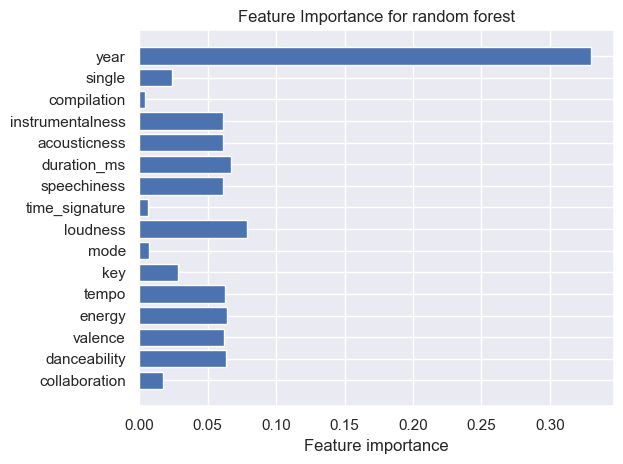

In [61]:
fig, ax = plt.subplots()
plt.barh(random_forest.feature_names_in_, random_forest.feature_importances_)
plt.title('Feature Importance for random forest')
plt.xlabel("Feature importance")
fig.tight_layout()
fig.savefig("features_rf.png")
plt.show();

# 4. Display Results

Please notice that due to the randomness of some models, we may get slightly different results. 

In [62]:
pd.DataFrame(results)

model   train_mse  train_R-squared    test_mse  \
0  Linear Regression (Baseline)  148.342486         0.117405  156.466228   
1              Ridge Regression  106.896308         0.363998  110.570192   
2              Lasso Regression  106.902098         0.363963  110.577084   
3            Poisson Regression  106.837782         0.332127  110.236616   
4             Gradient Boosting   93.793649         0.441955  102.797856   
5                       XGBoost   95.244220         0.433324  103.078952   
6                      Stacking   85.773424         0.489673  102.502031   
7     Single Best Decision Tree  136.636307         0.082159  141.449318   
8                       Bagging  136.475625         0.169886  148.913409   
9                 Random Forest  134.666875         0.189489  147.496136   

   test_R-squared  
0        0.084123  
1        0.352776  
2        0.352735  
3        0.322395  
4        0.398271  
5        0.396626  
6        0.400003  
7        0.046136  
8        0.050682  
9        0.045000

In [63]:
pd.DataFrame(results).to_csv("results.csv")

# 5. Extension: Forecast Song Popularity in 2022

In [64]:
with open('data_2022.json', 'r') as f:
    data_2022 = json.load(f)
    df_2022 = pd.DataFrame(data_2022)

# one-hot encoding for categorical data
df_2022[['compilation', 'single']] = enc.transform(df_2022[["type_release"]]).toarray()
df_2022["collaboration"] = df_2022["collaboration"].map({"Y": 1, "N": 0})

# scaling for numerical data
df_2022[cols_to_scale] = scaler.fit_transform(df_2022[cols_to_scale])
df_2022["year"] = pd.DatetimeIndex(df_2022['release_date']).year
df_2022['year'] = year_scaler.transform(df_2022[['year']])
df_2022.head()

artist_name                                       track_name  \
0      Izzamuzzic                                         Shootout   
1      Izzamuzzic                               Shootout (Sped Up)   
2          Knock2                                  dashstar* - VIP   
3  Dillon Francis  Don’t Let Me Let Go (with ILLENIUM & EVAN GIIA)   
4            Rezz                                       Puzzle Box   

                 track_id type_release  collaboration  danceability   valence  \
0  4pTkDIlpFNoeWbahu8pVXW       single              1      0.366319  0.903382   
1  3r44Otr6SVUja3SYsCuhVY       single              1      0.527975  1.837775   
2  0zXiTthYKCfvfwixJdn92o       single              0     -0.272605 -1.239640   
3  1Yqe3VYgjOhhJLtqkla2zc       single              1     -1.127070  0.234095   
4  5EhnuLMer8qAXEDwmLtyrW       single              1      0.620349 -0.622071   

     energy     tempo       key  ...  time_signature  speechiness  \
0 -1.087074 -1.668487 -0.911788  ...        0.112964    -0.232635   
1 -0.928008 -0.928769  1.299947  ...        0.112964    -0.285833   
2  1.210557 -0.033450 -0.082387  ...        0.112964    -0.112187   
3 -0.226935  0.800885  1.023480  ...        0.112964    -0.353084   
4 -1.617297 -1.330146 -1.188255  ...        0.112964    -0.517696   

   duration_ms  acousticness  instrumentalness  release_date  popularity  \
0     1.003776      0.930641          1.667303    2022-06-30          76   
1     0.283212      0.455041          1.765918    2022-07-08          76   
2    -1.094624     -0.534803         -0.057056    2022-07-29          63   
3    -0.213699     -0.417389         -0.885424    2022-07-08          65   
4    -0.122460      0.355957          1.470072    2022-03-04          61   

  compilation  single      year  
0           0       1  1.812654  
1           0       1  1.812654  
2           0       1  1.812654  
3           0       1  1.812654  
4           0       1  1.812654  

[5 rows x 22 columns]

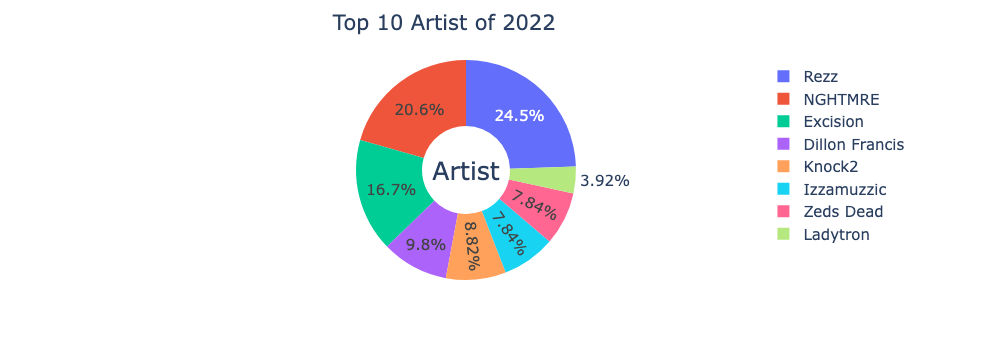

In [65]:
import plotly.express as px

artist_cnt = df_2022.artist_name.value_counts()
df_count = pd.DataFrame({"artist_name": artist_cnt.index, "count": artist_cnt.values})

fig = px.pie(df_2022.merge(df_count, how='left').head(10), values='count', names='artist_name', hole=0.4)
fig.update_layout(title='Top 10 Artist of 2022', font_size=15, title_x=0.45, annotations=[dict(text='Artist',font_size=25, showarrow=False, height=800, width=700)])
fig.update_traces(textfont_size=15,textinfo='percent')
fig.show()

## 5.1. Forecast 2022 Popularity Using Trained Models 

In [66]:
X_2022_baseline = df_2022[['collaboration', 'danceability', 'valence', 'energy', 'tempo', 'key',
       'mode', 'loudness', 'time_signature', 'speechiness', 'duration_ms',
       'acousticness', 'instrumentalness', 'compilation', 'single']
       ]
y_2022 = df_2022['popularity']
test_mse = mean_squared_error(y_2022, lr.predict(X_2022_baseline))
test_r2 = lr.score(X_2022_baseline, y_2022)

results_2022 = [{
    'model': "Linear Regression (Baseline)",
    'test_mse': test_mse,
    'test_R-squared': test_r2
}]

In [67]:
X_2022 = df_2022[['collaboration', 'danceability', 'valence', 'energy', 'tempo', 'key',
       'mode', 'loudness', 'time_signature', 'speechiness', 'duration_ms',
       'acousticness', 'instrumentalness', 'compilation', 'single','year']]

test_mse = mean_squared_error(y_2022, best_ridge.predict(X_2022))
test_r2 = best_ridge.score(X_2022, y_2022)

results_2022.append({
    'model': "Ridge Regression",
    'test_mse': test_mse,
    'test_R-squared': test_r2
})

In [68]:
test_mse = mean_squared_error(y_2022, best_lasso.predict(X_2022))
test_r2 = best_lasso.score(X_2022, y_2022)

results_2022.append({
    'model': "Lasso Regression",
    'test_mse': test_mse,
    'test_R-squared': test_r2
})

In [69]:
test_mse = mean_squared_error(y_2022, glm.predict(X_2022))
test_r2 = glm.score(X_2022, y_2022)

results_2022.append({
    'model': "Poisson Regression",
    'test_mse': test_mse,
    'test_R-squared': test_r2
})

In [70]:
test_mse = mean_squared_error(y_2022, reg.predict(X_2022))
test_r2 = reg.score(X_2022, y_2022)

results_2022.append({
    'model': "Gradient Boosting",
    'test_mse': test_mse,
    'test_R-squared': test_r2
})

In [71]:
test_mse = mean_squared_error(y_2022, xgb_reg.predict(X_2022))
test_r2 = xgb_reg.score(X_2022, y_2022)

results_2022.append({
    'model': "XGBoost",
    'test_mse': test_mse,
    'test_R-squared': test_r2
})

In [72]:
test_mse = mean_squared_error(y_2022, stacked_reg.predict(X_2022))
test_r2 = stacked_reg.score(X_2022, y_2022)

results_2022.append({
    'model': "Stacking",
    'test_mse': test_mse,
    'test_R-squared': test_r2
})

In [73]:
best_depth = 7
single_dt = DecisionTreeClassifier(max_depth=best_depth).fit(X_train, y_train)

test_mse = mean_squared_error(y_2022, single_dt.predict(X_2022))
test_r2 = single_dt.score(X_2022, y_2022)

results_2022.append({
    'model': "Single Best Decision Tree",
    'test_mse': test_mse,
    'test_R-squared': test_r2
})

In [74]:
test_mse = mean_squared_error(y_2022, bagging.predict(X_2022))
test_r2 = bagging.score(X_2022, y_2022)

results_2022.append({
    'model': "Bagging",
    'test_mse': test_mse,
    'test_R-squared': test_r2
})

In [75]:
test_mse = mean_squared_error(y_2022, random_forest.predict(X_2022))
test_r2 = random_forest.score(X_2022, y_2022)

results_2022.append({
    'model': "Random Forest",
    'test_mse': test_mse,
    'test_R-squared': test_r2
})

In [76]:
pd.DataFrame(results_2022)

model    test_mse  test_R-squared
0  Linear Regression (Baseline)  266.010925       -1.374695
1              Ridge Regression  114.302234       -0.020383
2              Lasso Regression  114.405204       -0.021302
3            Poisson Regression  119.735095       -0.045907
4             Gradient Boosting  116.951178       -0.044030
5                       XGBoost  119.118972       -0.063382
6                      Stacking  112.874678       -0.007639
7     Single Best Decision Tree  131.882000        0.042000
8                       Bagging  162.823000        0.031000
9                 Random Forest  167.776000        0.033000

In [77]:
pd.DataFrame(results_2022).to_csv("results_2022.csv")

## 5.2. Forecast 2022 Popularity Using Per Year Data From 2012-2021

In [78]:
with open('all_data.json', 'r') as f:
    data = json.load(f)
    df = pd.DataFrame(data)

In [79]:
# preprocess
enc = OneHotEncoder(drop='first', dtype=int)
enc.fit(df[["type_release"]])
df[['compilation','single']] = enc.transform(df[["type_release"]]).toarray()
# encode "collaboration"
df["collaboration"] = df["collaboration"].map({"Y":1, "N":0})
# add 'year' feature
df["year"] = pd.DatetimeIndex(df['release_date']).year

In [80]:
# scaling
cols_to_scale = ['danceability', 'valence', 'energy', 'tempo',
                 'loudness', 'speechiness', 'duration_ms',
                 'acousticness', 'instrumentalness','key','time_signature']
scaler = StandardScaler()
df[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

In [81]:
# set test data
X_2022 = df_2022[['collaboration', 'danceability', 'valence', 'energy', 'tempo', 'key',
       'mode', 'loudness', 'time_signature', 'speechiness', 'duration_ms',
       'acousticness', 'instrumentalness', 'compilation', 'single']
       ]
y_2022 = df_2022['popularity']

In [82]:
# predict 2022 song pupularity using each year's data from 2012 - 2021
results_per_year = []
for yr in range(2012,2022):
    df_per_year = df[df["year"]==yr]
    # split train and test data
    predictors = ['collaboration', 'danceability', 'valence', 'energy', 'tempo', 'key',
       'mode', 'loudness', 'time_signature', 'speechiness', 'duration_ms',
       'acousticness', 'instrumentalness', 'compilation', 'single']
    X = df_per_year[predictors]
    y = df_per_year['popularity']
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=109)
    # train a stacking model
    estimators = [
    ('lr', LinearRegression()),
    ('lasso', LassoCV()), 
    ('ridge', RidgeCV()),
    ('glm', PoissonRegressor()),
    ('boosting', GradientBoostingRegressor(max_depth=5))
    ]
    stacked_reg = StackingRegressor(
      estimators=estimators, 
      final_estimator=LinearRegression()
      )
    stacked_reg.fit(X_train, y_train)
    training_mse = mean_squared_error(y_train, stacked_reg.predict(X_train))
    test_mse = mean_squared_error(y_test, stacked_reg.predict(X_test))
    training_r2 = stacked_reg.score(X_train, y_train)
    test_r2 = stacked_reg.score(X_test, y_test)
    results_per_year.append({
    'year': yr,
    'train_mse': training_mse,
    'train_R-squared': training_r2, 
    'test_mse': test_mse,
    'test_R-squared': test_r2
    })

In [83]:
pd.DataFrame(results_per_year)

year  train_mse  train_R-squared   test_mse  test_R-squared
0  2012  66.070891         0.237866  86.032113        0.043935
1  2013  77.559503         0.225833  79.815374        0.043384
2  2014  57.592293         0.292116  76.315315        0.008699
3  2015  69.368137         0.148144  80.236976        0.013080
4  2016  49.555318         0.344291  71.821344       -0.013410
5  2017  54.898658         0.225130  49.241676        0.100627
6  2018  34.622902         0.432228  61.292643        0.050933
7  2019  51.204793         0.177915  57.364742        0.057276
8  2020  40.680483         0.326663  64.087626        0.101376
9  2021  43.529326         0.379079  64.994067        0.048641

In [84]:
pd.DataFrame(results_per_year).to_csv("results_per_year.csv")

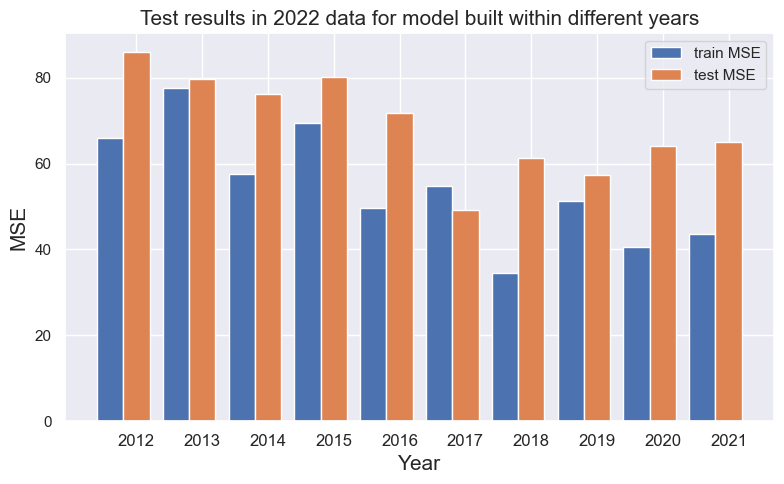

In [86]:
df = pd.read_csv('results_per_year.csv')
fig, ax = plt.subplots(figsize=(8,5))
barWidth = 0.4
br1 = np.arange(len(df["year"]))
br2 = [x + barWidth for x in br1]

plt.bar(br1, df["train_mse"], width = barWidth, label = "train MSE")
plt.bar(br2, df["test_mse"], width = barWidth,  label = "test MSE")
plt.xticks([r + barWidth for r in range(len(df['year']))],
        df['year'], fontsize=12)
plt.xlabel("Year", fontsize=15)
plt.ylabel("MSE", fontsize=15)
plt.title("Test results in 2022 data for model built within different years", fontsize=15)
plt.legend()
fig.tight_layout()
fig.savefig("ext_mse.png")
plt.show()

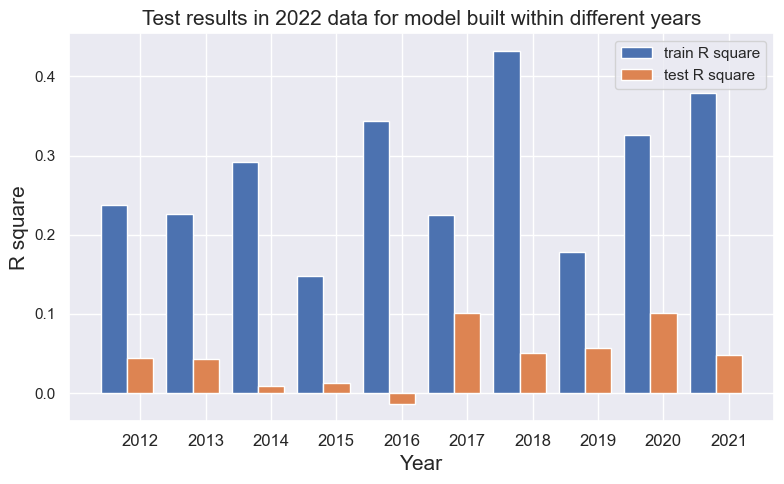

In [87]:
fig, ax = plt.subplots(figsize=(8,5))
barWidth = 0.4
br1 = np.arange(len(df["year"]))
br2 = [x + barWidth for x in br1]

plt.bar(br1, df["train_R-squared"], width = barWidth, label = "train R square")
plt.bar(br2, df["test_R-squared"], width = barWidth,  label = "test R square")
plt.xticks([r + barWidth for r in range(len(df['year']))],
        df['year'], fontsize=12)
plt.xlabel("Year", fontsize=15)
plt.ylabel("R square", fontsize=15)
plt.title("Test results in 2022 data for model built within different years", fontsize=15)
plt.legend()
fig.tight_layout()
fig.savefig("ext_r2.png")
plt.show()